In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from matplotlib import pyplot as plt
from amb import *
import xarray as xr
import anndata
import joblib

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
age_palette = get_age_palette()

In [3]:
# leg = [f'{ct}.{age}' for age in ['8wk','9mo','18mo']]
# leg

## plot prob

In [4]:
def get_all_diff_boundary(ct):
    indir = '/data/female-amb/loop/'
    ddir = f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}'
    ldir = f'/data/female-amb/Diff.Result/loop_ct_age/diff/{ct}'
    cdir = f'/home/qzeng_salk_edu/project/240204-redo-compartment/Call.DiffComp.CellType.Age/{ct}'
    
    leg = [f'{ct}.{age}' for age in ['8wk','9mo','18mo']]
    bound_count_ct = pd.read_hdf(f'{ddir}/{ct}_boundcount.hdf', key='data').loc[leg]
    cell_count_ct = pd.read_csv(f'{ddir}/{ct}_cellcount.csv.gz', index_col=0, header=0).loc[leg]['count']
    bound_prob_ct = bound_count_ct /np.array(cell_count_ct)[:, None]

    binall = pd.read_hdf(f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}/{ct}_bin_stats.hdf', key='data')
    selb = (binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc'])
    selected_bins = selb[selb].index
    all_bins = binall.index

    tmp = bound_prob_ct[selected_bins].T
    tmp = tmp[leg]
    tmp.columns = ['8wk','9mo','18mo']
    tmp['18mo-8wk'] = tmp['18mo'] - tmp['8wk']
    tmp['celltype'] = ct
    return tmp

In [6]:
ct  = 'Oligo_NN'
binall = pd.read_hdf(
    f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}/{ct}_bin_stats.hdf', 
    key='data')

In [8]:
binall.sort_values('ins_lm')

,chrom,start,end,chi2filter,ins_lm,probdiff,chi2_sc,insfc,diff_sc
chr1_0,chr1,0,25000,False,0,0.000000,0.000000,1.020000,0
chr11_2451,chr11,61275000,61300000,False,0,0.000428,0.015558,0.350259,0
chr11_2450,chr11,61250000,61275000,False,0,0.008554,4.239364,0.337358,0
chr11_2449,chr11,61225000,61250000,False,0,0.013259,6.481632,0.312477,0
chr11_2448,chr11,61200000,61225000,False,0,0.004705,0.470419,0.282705,0
...,...,...,...,...,...,...,...,...,...
chr2_2048,chr2,51200000,51225000,False,1,0.013259,3.202309,0.231515,0
chr13_4450,chr13,111250000,111275000,False,1,0.014115,7.624725,0.329696,0
chr9_3706,chr9,92650000,92675000,False,1,0.002139,0.178320,0.269134,0
chr2_2060,chr2,51500000,51525000,False,1,0.010265,4.241405,0.280835,0


In [5]:
allcts = [path.split('/')[-1] for path in glob.glob('/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/*') 
          if path.split('/')[-1] != 'notebooks']

In [6]:
all_df = []
for ct in allcts:
    tmpdf = get_all_diff_boundary(ct)
    all_df.append(tmpdf)
all_df = pd.concat(all_df)

In [7]:
shared_use_cts = joblib.load('/home/qzeng_salk_edu/project/shared_use_cts')
shared_use_cts = [ct.replace('/','').replace(' ','_') for ct in shared_use_cts]

In [8]:
all_df = all_df[all_df['celltype'].isin(shared_use_cts)]

In [9]:
cell_counts = all_df['celltype'].value_counts()
cell_counts = pd.DataFrame(cell_counts)
cell_counts['celltype'] = cell_counts.index
cell_counts.head()

,count,celltype
celltype,,
DG_Glut,777,DG_Glut
CA1-ProS_Glut,255,CA1-ProS_Glut
L23_IT_CTX_Glut,178,L23_IT_CTX_Glut
Astro-TE_NN,146,Astro-TE_NN
CA3_Glut,138,CA3_Glut


In [11]:
cell_counts = cell_counts[cell_counts['count'] > 50]

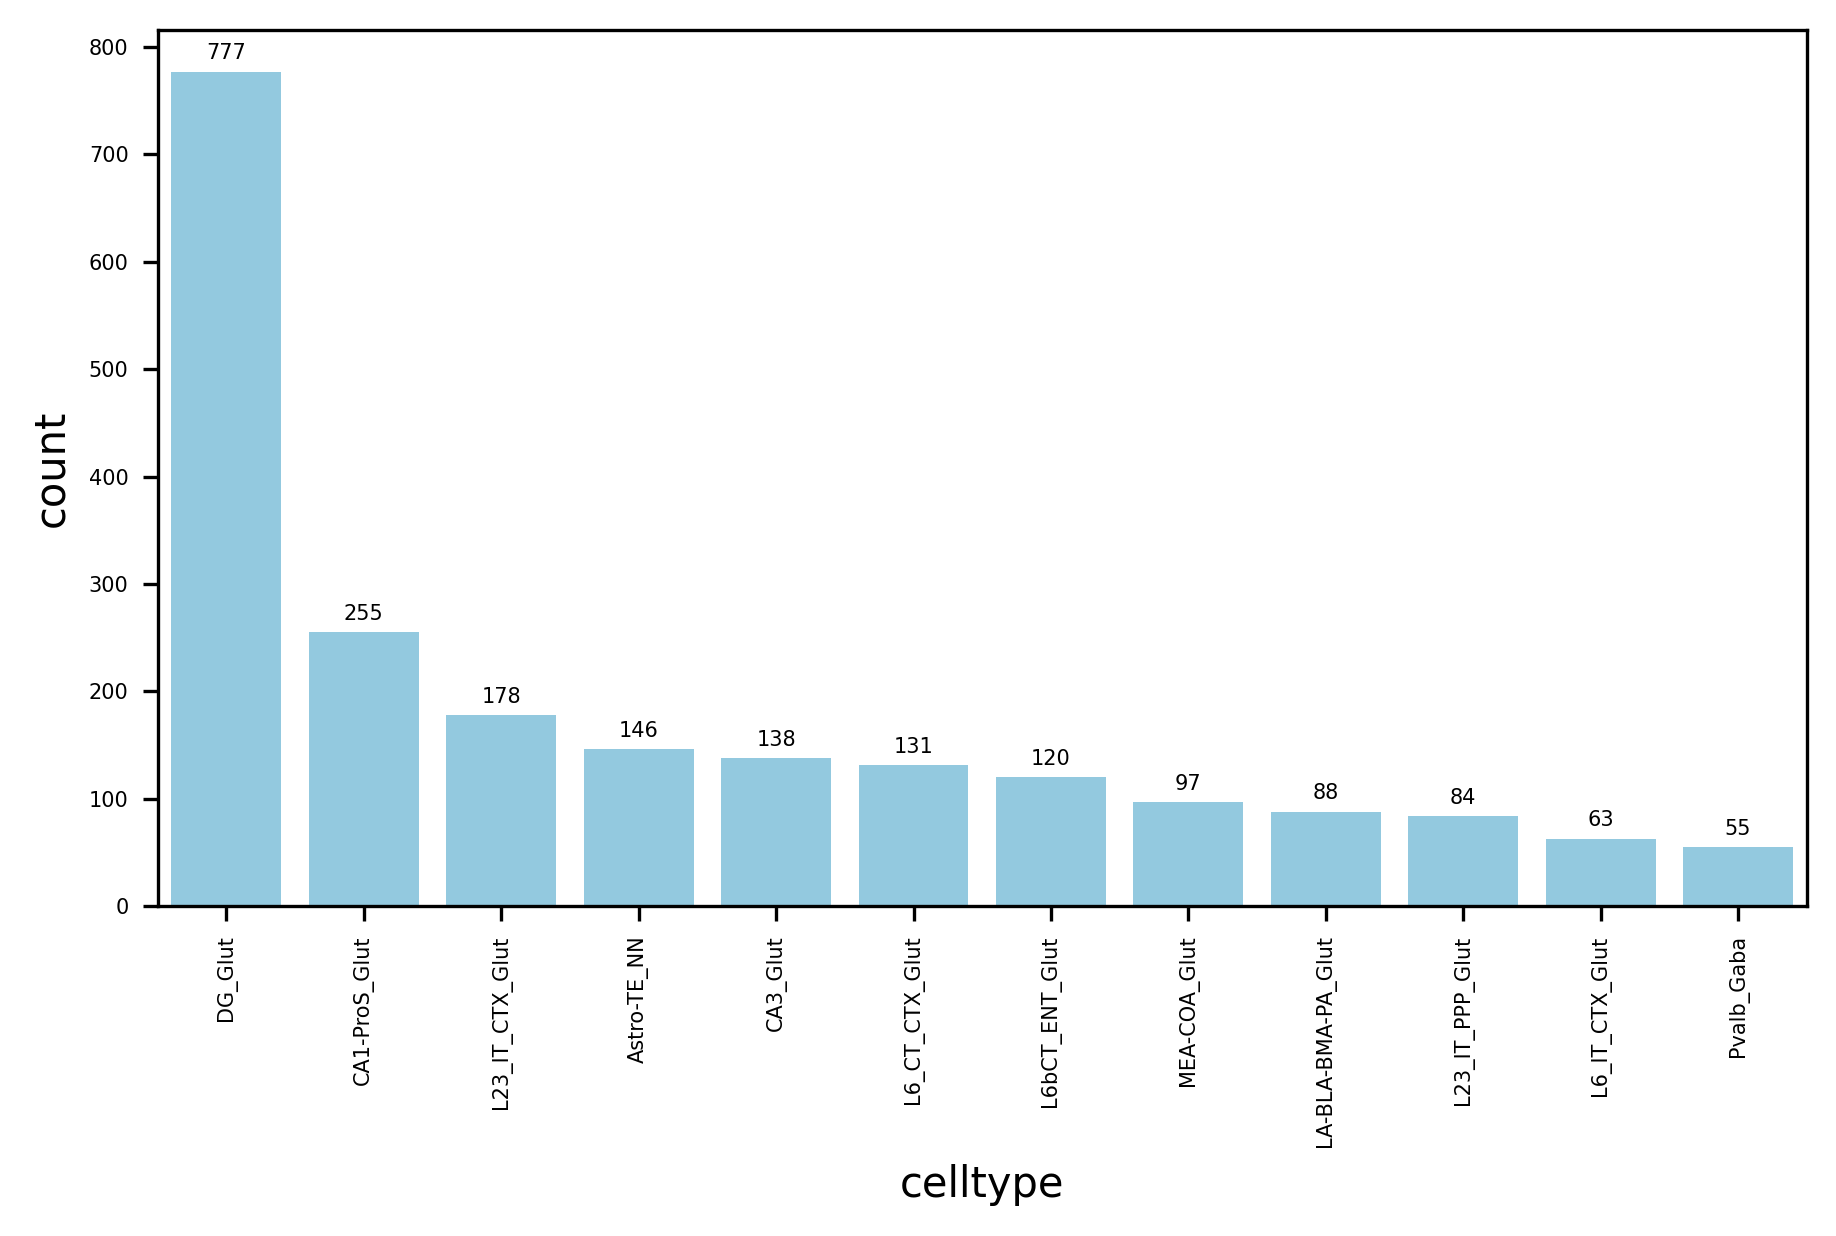

In [15]:
fig, ax = plt.subplots(figsize = (6,4), dpi = 300, constrained_layout = True)
sns.barplot(data = cell_counts,
            y = 'count',
            x = 'celltype',
            ax= ax,
            color = 'skyblue')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = 5)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 5)

# Annotate each bar with its 'counts' value
for i in ax.containers:
    ax.bar_label(i, fmt='%d', label_type='edge', padding=2, fontsize = 5)

fig.savefig(f"figure/morethan50.Barplot.DiffBoundary.Celltype.pdf", bbox_inches = 'tight')

In [13]:
decrease_db = all_df[all_df['18mo-8wk'] < 0]
splitinng_domain = all_df[(all_df['18mo-8wk'] > 0) & (all_df['8wk'] < 0.1)]
increase_db = all_df[all_df['18mo-8wk'] > 0]
decrease_db.shape[0], splitinng_domain.shape[0], increase_db.shape[0]

(108, 1065, 2597)

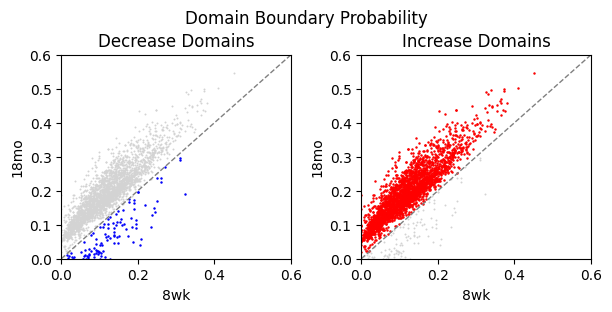

In [14]:
fig, axes = plt.subplots(figsize = (6,3), ncols = 2, dpi = 100, constrained_layout = True)

ax = axes[0]
sns.scatterplot(data = all_df,
                ax = ax,
                linewidth = 0,
                x ='8wk',
                y = '18mo',
                color = 'lightgrey',
                rasterized = True,
               s = 2)
sns.scatterplot(data = decrease_db,
                linewidth = 0,
                ax = ax,
                x ='8wk',
                y = '18mo',
                rasterized = True,
               color = 'blue',
               s = 3)
ax.set(xlim=[0, 0.6], ylim=[0, 0.6])
ax.plot([0, 0.6], [0, 0.6], color="grey", ls = '--', lw = 1)
ax.set_title('Decrease Domains')

ax = axes[1]
sns.scatterplot(data = all_df,
                linewidth = 0,
                ax = ax,
                x ='8wk',
                y = '18mo',
                color = 'lightgrey',
                rasterized = True,
               s = 2)
sns.scatterplot(data = increase_db,
                linewidth = 0,
                ax = ax,
                x ='8wk',
                y = '18mo',
                rasterized = True,
               color = 'red',
               s = 3)
ax.set(xlim=[0, 0.6], ylim=[0, 0.6])
ax.plot([0, 0.6], [0, 0.6], color="grey", ls = '--', lw = 1)
ax.set_title('Increase Domains')

fig.suptitle('Domain Boundary Probability')
fig.savefig(f"figure/Scatter.Boundary.Probability.pdf", bbox_inches = 'tight')

## plot ins score

In [15]:
decrease_db['domain_id_celltype'] = decrease_db.index + '_' + decrease_db['celltype']
increase_db['domain_id_celltype'] = increase_db.index + '_' + increase_db['celltype']
splitinng_domain['domain_id_celltype'] = splitinng_domain.index + '_' + splitinng_domain['celltype']

In [16]:
decrease_domains = decrease_db['domain_id_celltype']
increase_domains = increase_db['domain_id_celltype']
split_domains = splitinng_domain['domain_id_celltype']

In [17]:
def get_all_diff_boundary(ct):
    indir = '/data/female-amb/loop/'
    ddir = f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}'
    
    leg = [f'{ct}.{age}' for age in ['8wk','9mo','18mo']]
    
    binall = pd.read_hdf(f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}/{ct}_bin_stats.hdf', key='data')
    selb = (binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc'])
    selected_bins = selb[selb].index
    
    ins_count = xr.open_dataset(f'/home/qzeng_salk_edu/project/240205-domain/hicluster_bulk_domain/{ct}.insulation.nc')
    ins_count = ins_count.sel({'bin': (ins_count['bin_chrom']!='chrX')})
    ins_count['ratio'] = (ins_count.sel({'type':'inter'})['__xarray_dataarray_variable__'] / ins_count.sel({'type':'intra'}))['__xarray_dataarray_variable__']
    ins = ins_count['ratio'].to_pandas().loc[leg]
    ins.columns = binall.index

    tmp = ins[selected_bins].T
    tmp = tmp[leg]
    tmp.columns = ['8wk','9mo','18mo']
    #tmp = tmp[tmp[f'{ct}.8wk'] < tmp[f'{ct}.18mo']]
    tmp['18mo-8wk'] = tmp['18mo'] - tmp['8wk']
    tmp['celltype'] = ct
    return tmp

In [18]:
allcts = [path.split('/')[-1] for path in glob.glob('/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/*') 
          if path.split('/')[-1] != 'notebooks']

In [19]:
all_df = []
for ct in allcts:
    tmpdf = get_all_diff_boundary(ct)
    all_df.append(tmpdf)

In [20]:
all_df = pd.concat(all_df)

In [21]:
all_df = all_df[all_df['celltype'].isin(shared_use_cts)]

In [22]:
all_df['domain_id_celltype'] = all_df.index + '_' + all_df['celltype']

In [23]:
decrease_db = all_df[all_df['domain_id_celltype'].isin(decrease_domains)]
splitinng_domain = all_df[all_df['domain_id_celltype'].isin(split_domains)]
increase_db = all_df[all_df['domain_id_celltype'].isin(increase_domains)]
decrease_db.shape[0], splitinng_domain.shape[0], increase_db.shape[0]

(108, 1065, 2597)

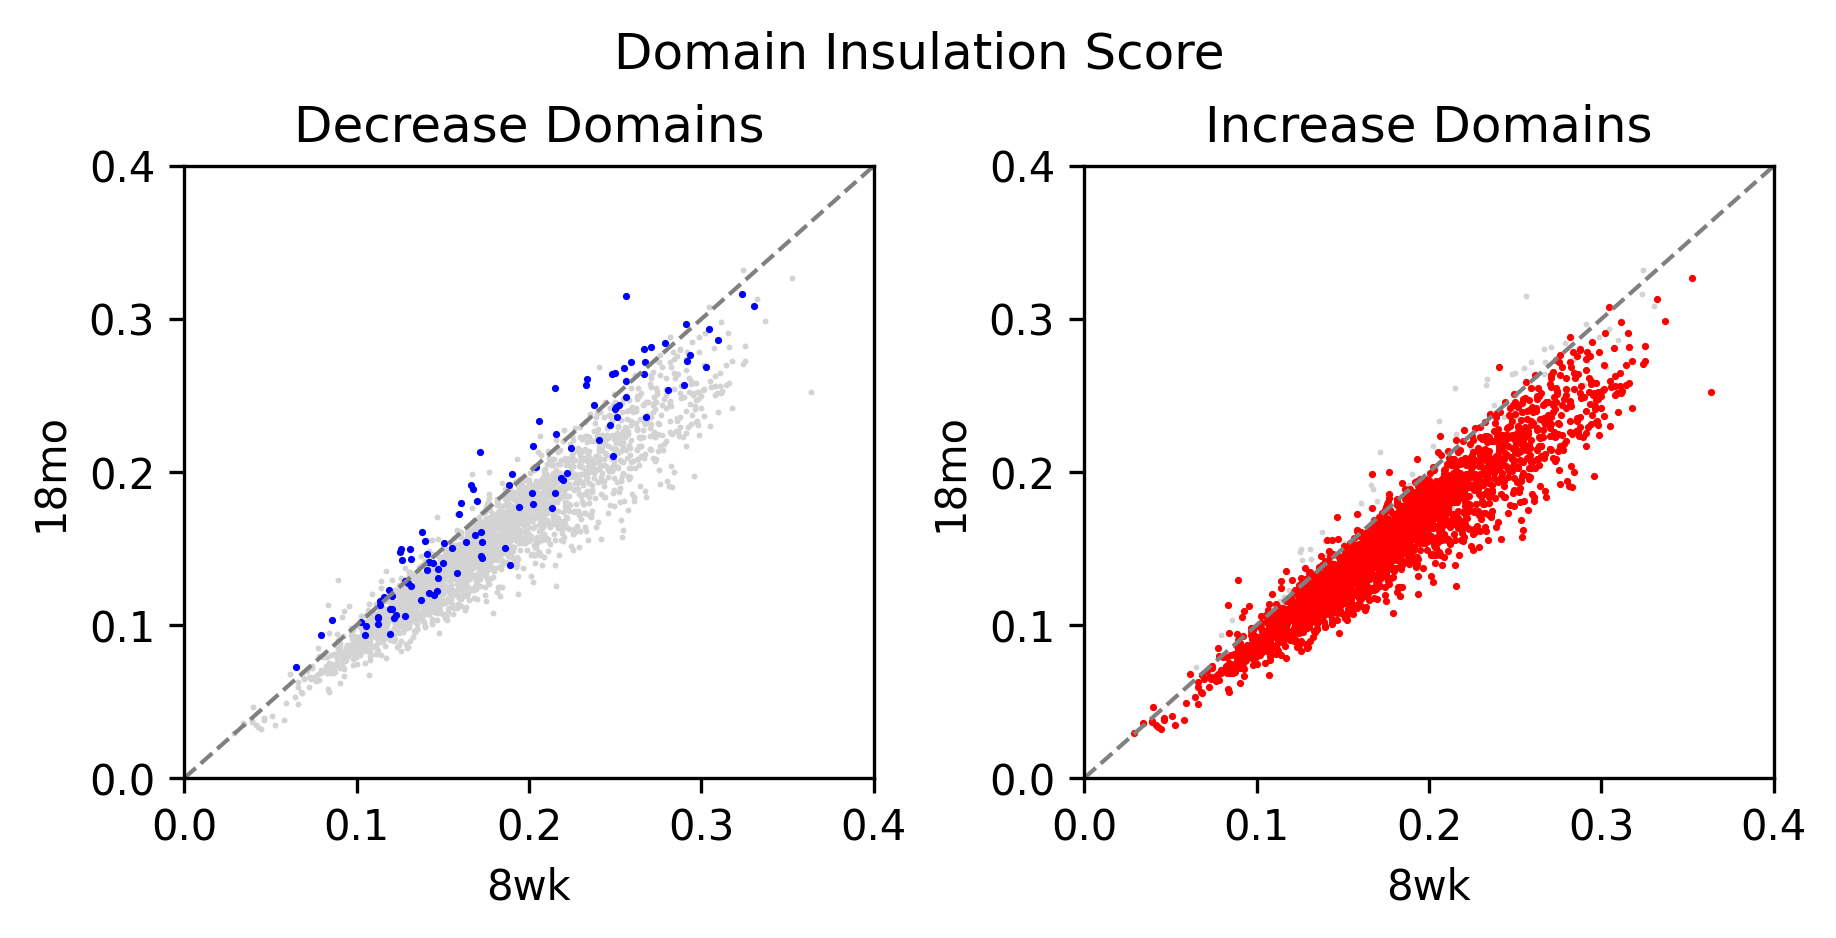

In [24]:
fig, axes = plt.subplots(figsize = (6,3), ncols = 2, dpi = 300, constrained_layout = True)

ax = axes[0]
sns.scatterplot(data = all_df,
                ax = ax,
                linewidth = 0,
                x ='8wk',
                y = '18mo',
                color = 'lightgrey',
                rasterized = True,
                s = 2)
sns.scatterplot(data = decrease_db,
                linewidth = 0,
                ax = ax,
                x ='8wk',
                y = '18mo',
                rasterized = True,
               color = 'blue',
               s = 3)
ax.set(xlim=[0, 0.4], ylim=[0, 0.4])
ax.plot([0, 0.4], [0, 0.4], color="grey", ls = '--', lw = 1)
ax.set_title('Decrease Domains')

ax = axes[1]
sns.scatterplot(data = all_df,
                linewidth = 0,
                ax = ax,
                x ='8wk',
                y = '18mo',
                color = 'lightgrey',
                rasterized = True,
               s = 2)
sns.scatterplot(data = increase_db,
                linewidth = 0,
                ax = ax,
                x ='8wk',
                y = '18mo',
                rasterized = True,
               color = 'red',
               s = 3)
ax.set(xlim=[0, 0.4], ylim=[0, 0.4])
ax.plot([0, 0.4], [0, 0.4], color="grey", ls = '--', lw = 1)
ax.set_title('Increase Domains')

fig.suptitle('Domain Insulation Score')
fig.savefig(f"figure/Scatter.Insulation.Score.pdf", bbox_inches = 'tight')

In [1]:
!pwd

/home/qzeng_salk_edu/project/240522_fig4_plots
